In [1]:
#!pip install tensorflow

In [2]:
#!pip install Pillow

In [3]:
#!pip install scipy

In [4]:
#!pip install SimpleITK

In [5]:
#pip install imageio

In [6]:
import sys, pkgutil
print("Kernel Python:", sys.executable)



Kernel Python: C:\Users\hp\anaconda3\python.exe


In [7]:
# install GPU PyTorch (CUDA 11.8 build) 
# Cuz my GPU is NVIDIA 1050 TI
#%pip install --upgrade --index-url https://download.pytorch.org/whl/cu118 torch torchvision torchaudio

## Importing Libraries

In [8]:
import SimpleITK as sitk
import tensorflow
print(tensorflow.__version__)

2.20.0


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns 
import random
import os, re
import glob
import imageio.v2 as imageio
import multiprocessing
import ipywidgets as widgets
import torch
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F


from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from IPython.display import display
from pathlib import Path
from collections import Counter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix
from tqdm import tqdm
from PIL import Image
import imageio.v2 as imageio
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

## Firstly setting up path

In [10]:
ROOT = r"D:\CAPSTONE\LIDC\LIDC-IDRI-Preprocessing\data\Image"
meta_csv  = r"D:\CAPSTONE\LIDC\LIDC-IDRI-Preprocessing\data\Meta\lidc_slices.csv" 
IMG_PNG = [".png"]  

df = pd.read_csv(meta_csv)

# Labelling based on Maligancy as we get from Meta CSV
USE_MALIGNANCY_POLICY = True
BENIGN_MAX = 2.5
MALIGN_MIN = 3.5

## Global Hyperparameters Configuration

•**IMG_SIZE** : balances detail for lung textures

•**BATCH_SIZE** : maximizes throughput without on GPUs

•**LR** : for cosine annealing reduces LR over time for smoother, stronger convergence

•**WEIGHT_DECAY** : to reduce overfitting

•**NUM_WORKERS** : to avoid dataloader issues 

•**VAL_SIZE** : 20% for unbiased validation

•**SEED** : reproducibility for splits and training, default

•**PATIENCE** : stoppage for epochs or breaks

•**PRETRAINED** : ImageNet features for faster convert

•**FREEZE_BACKBONE_EPOCHS** : full fine-tune from the start

•**AUGMENT** : train-time transforms to boost generalization


In [11]:
IMG_SIZE = 256
BATCH_SIZE = 24 
EPOCHS = 30 
LR = 1e-4
WEIGHT_DECAY = 1e-4 
NUM_WORKERS = 0 
VAL_SIZE = 0.2
SEED = 42
PATIENCE = 8
PRETRAINED = True
FREEZE_BACKBONE_EPOCHS = 0
AUGMENT = True

SAVE_BEST_PATH = "best_mawnet.pt"

In [12]:
print(df.head(20))

    patient_id  nodule_no  slice_no       original_image           mask_image  \
0            1          0         0  0001_NI000_slice000  0001_MA000_slice000   
1            1          0         1  0001_NI000_slice001  0001_MA000_slice001   
2            1          0         2  0001_NI000_slice002  0001_MA000_slice002   
3            1          0         3  0001_NI000_slice003  0001_MA000_slice003   
4            1          0         4  0001_NI000_slice004  0001_MA000_slice004   
5            1          0         5  0001_NI000_slice005  0001_MA000_slice005   
6            1          0         6  0001_NI000_slice006  0001_MA000_slice006   
7            1          0         7  0001_NI000_slice007  0001_MA000_slice007   
8            1          0         8  0001_NI000_slice008  0001_MA000_slice008   
9            1          0         9  0001_NI000_slice009  0001_MA000_slice009   
10           1          0        10  0001_NI000_slice010  0001_MA000_slice010   
11           1          0   

**Counting total number of images**

In [13]:
# Collect all PNG paths recursively
all_images = [
    os.path.join(root, f)
    for root, _, files in os.walk(ROOT)
    for f in files if f.lower().endswith('.png')
]

print(f"Total images found: {len(all_images)}")

Total images found: 59503


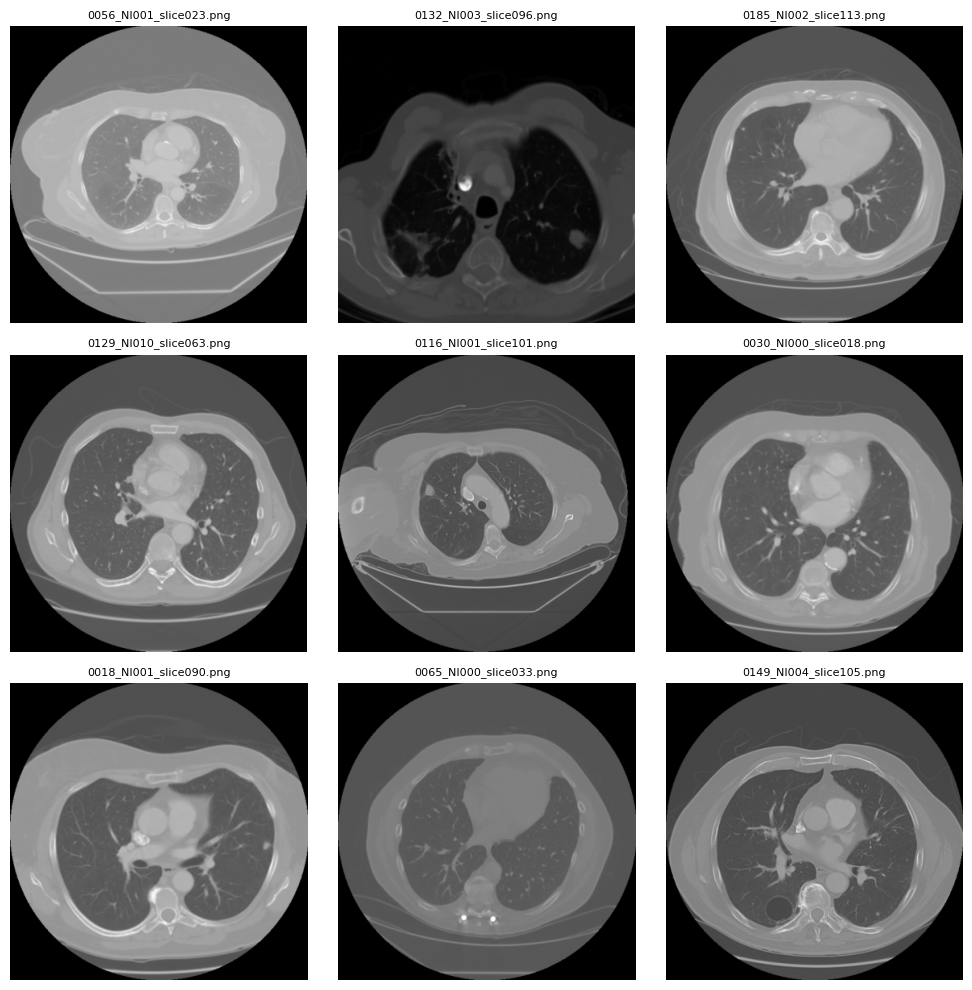

In [14]:
# Randomly selecting 9 samples for visualisation
sample_images = random.sample(all_images, 9)

# Displaying them 10 x 10
plt.figure(figsize=(10, 10))
for i, img_path in enumerate(sample_images, 1):
    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i)
    plt.imshow(img, cmap='gray')
    plt.title(os.path.basename(img_path), fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

**Viewing my system Core**

In [15]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce GTX 1050 Ti


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Model training on:", device)

Model training on: cuda


# Data Parsing

### Label Mapping

Here, 

**find_all_images()** scan all images files with allowed extensions to quickly map images names and related paths for indexing

**guess_label_column()** detects the column containing class labels (e.g., cancer vs non-cancer)

**guess_image_key_column()** Identifies which DataFrame column holds image filenames or paths

**guess_patient_column()** the column that uniquely identifies patients or series

**norm_patient_token()** normalizes patient IDs into consistent 4-digit tokens for data consistency

**to_int_label():** converting string-based class names (benign, malignant) into integer labels (0, 1, 2)


In [17]:
def find_all_images(root_dir: str, exts):
    root = Path(root_dir)
    files = []
    for ext in exts:
        files.extend(root.rglob(f"*{ext}"))
    index = {}
    for p in files:
        key1 = p.name.lower()
        key2 = str(p).replace(str(root)+os.sep, "").replace("\\", "/").lower()
        index[key1] = p
        index[key2] = p
    return index, files

def guess_label_column(df: pd.DataFrame):
    candidates = ["label","is_cancer","target","y","cancer","class","malignant","benign_malignant_normal"]
    for c in candidates:
        if c in df.columns: return c
    for c in df.columns:
        ser = df[c].dropna().astype(str).str.lower()
        if set(ser.unique()).issubset(set(["0","1","2"])):
            return c
    raise ValueError("No label column found. Add one of: label, is_cancer, target, y, cancer, class, malignant")

def guess_image_key_column(df: pd.DataFrame):
    candidates = ["filename","image","img","slice_name","slice_id","path","filepath","relative_path"]
    for c in candidates:
        if c in df.columns: return c
    for c in df.columns:
        col = df[c].astype(str)
        if col.str.contains(r"\.(?:png|jpe?g|bmp|tif)$", case=False, regex=True, na=False).any():
            return c
    return None

def guess_patient_column(df: pd.DataFrame):
    cand = ["patient","patient_id","patientid","pid","seriesuid","series_uid","study_id","LIDC_IDRI","lidc_id","lidc"]
    for c in cand:
        if c in df.columns: return c
    for c in df.columns:
        if df[c].astype(str).str.contains("LIDC-IDRI", case=False, regex=False).any():
            return c
    return None

def norm_patient_token(x) -> str:
    s = str(x).strip()
    m = re.search(r"(\d{1,4})(?!.*\d)", s)
    if m: return f"{int(m.group(1)):04d}"
    m = re.search(r"(\d+)", s)
    if m: return f"{int(m.group(1)):04d}"
    return None

def to_int_label(x):
    if isinstance(x, str):
        t = x.strip().lower()
        if t in ["normal","norm","0"]: return 0
        if t in ["benign","1","true","yes","pos","positive"]: return 1
        if t in ["malignant","2"]: return 2
        try: return int(float(t))
        except: return 0
    try: return int(x)
    except: return 0

### Lung CT Slice Classification

In [18]:
#Handling 2D CT image slices
class SliceDataset(Dataset):
    def __init__(self, df, img_size=224, train=True, augment=True):
        self.df = df.reset_index(drop=True)
        # normalized to the same distribution as the data they were trained on
        mean = [0.485, 0.456, 0.406]
        std  = [0.229, 0.224, 0.225]

        tfms = []
        if train and augment:
            tfms += [
                transforms.RandomResizedCrop(img_size, scale=(0.80, 1.0)),
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomVerticalFlip(0.2),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.15, contrast=0.15),
                transforms.GaussianBlur(3),
            ]
        else:
            tfms += [transforms.Resize((img_size, img_size))]

        self.tfms = transforms.Compose(tfms + [
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

#loading the DataFrame to setup image transforms 
#data augmentation for training or resizing for validation/testing
    def __len__(self): return len(self.df)

#converting it to RGB to apply transformations
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        p = Path(row["path"])
        with Image.open(p) as im:
            im = im.convert("RGB")
        x = self.tfms(im)
        y = int(row["label"])
        return x, y


**Source:** https://pytorch.org/vision/stable/models.html#classification and
Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). ImageNet Classification with Deep Convolutional Neural Networks (AlexNet). NeurIPS 2012

# MAW-Net (Multi-Attention Wavelet U-Net) with Dual Encoders

In [19]:
class AttentionGate(nn.Module):
    """
    getting features using gating from decoder and keeping salient regions to irradicate noise
    """
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.Sigmoid())
    def forward(self, g, x):
        psi = torch.relu(self.W_g(g) + self.W_x(x))
        psi = self.psi(psi)
        return x * psi

class UpBlock(nn.Module):
    """
    to upsample images + attention gate + double the conv layer and decoding to sharpen details
    """
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, 2)
        self.ag = AttentionGate(out_ch, skip_ch, max(out_ch//2, 1))
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch+skip_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x, skip):
        x = self.up(x)
        skip = self.ag(x, skip)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

def make_haar_kernels():
    """
    builds fixed 2 × 2 Haar filters (LL, LH, HL, HH)
    for a wavelet-like decomposition
    """
    h = torch.tensor([1/np.sqrt(2), 1/np.sqrt(2)], dtype=torch.float32)
    g = torch.tensor([1/np.sqrt(2),-1/np.sqrt(2)], dtype=torch.float32)
    LL = torch.outer(h, h); LH = torch.outer(h, g)
    HL = torch.outer(g, h); HH = torch.outer(g, g)
    bank = torch.stack([LL, LH, HL, HH], dim=0).unsqueeze(1)
    return bank

In [20]:
class WaveletLike(nn.Module):
    """
    depthwise conv with Haar to stride=2
    This one for caputring frequency
    """
    def __init__(self, in_ch=3):
        super().__init__()
        k = make_haar_kernels()
        self.weight = nn.Parameter(k.repeat(in_ch,1,1,1), requires_grad=False)
        self.in_ch = in_ch
    def forward(self, x):
        B,C,H,W = x.shape
        return F.conv2d(x, self.weight, stride=2, padding=0, groups=C)

class WaveletEncoder(nn.Module):
    """
    Wavelet-like encoder stride2 
    This produces a multi-scale feature at /4, /8, /16, /32
    """
    def __init__(self, in_ch=3, base=32):
        super().__init__()
        self.w = WaveletLike(in_ch=in_ch)  # stride=2 -> /2
        wch = 4*in_ch
        # NOTE: stride=2 here to go from /2 -> /4 (matches ResNet's layer1 spatial size)
        self.block1 = nn.Sequential(
            nn.Conv2d(wch, base, 3, stride=2, padding=1), nn.BatchNorm2d(base), nn.ReLU(inplace=True)
        )  # /4
        self.block2 = nn.Sequential(
            nn.Conv2d(base, base*2, 3, stride=2, padding=1), nn.BatchNorm2d(base*2), nn.ReLU(inplace=True)
        )  # /8
        self.block3 = nn.Sequential(
            nn.Conv2d(base*2, base*4, 3, stride=2, padding=1), nn.BatchNorm2d(base*4), nn.ReLU(inplace=True)
        )  # /16
        self.block4 = nn.Sequential(
            nn.Conv2d(base*4, base*8, 3, stride=2, padding=1), nn.BatchNorm2d(base*8), nn.ReLU(inplace=True)
        ) 

    def forward(self, x):
        x = self.w(x)         # /2
        f1 = self.block1(x)   # /4
        f2 = self.block2(f1)  # /8
        f3 = self.block3(f2)  # /16
        f4 = self.block4(f3)  # /32
        return [f1, f2, f3, f4]


class ResNetEncoder(nn.Module):
    """
    encoder (resnet18) for strong semantic features
    """
    def __init__(self, pretrained=True):
        super().__init__()
        try:
            weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
            m = models.resnet18(weights=weights)
        except Exception:
            m = models.resnet18(weights=None)
        self.stem = nn.Sequential(m.conv1, m.bn1, m.relu, m.maxpool)
        self.layer1 = m.layer1
        self.layer2 = m.layer2
        self.layer3 = m.layer3
        self.layer4 = m.layer4
    def forward(self, x):
        x0 = self.stem(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        return [x1, x2, x3, x4]

class MAWNet(nn.Module):
    """
    upsampling path: 512 to 256 to 128 to 64 and 32 to restore resolution 
    while mixing high/low features. This is also a part of nodule localization
    """
    def __init__(self, num_classes=2, pretrained=True):
        super().__init__()
        self.res = ResNetEncoder(pretrained=pretrained)
        self.wav = WaveletEncoder(in_ch=3, base=32)
        # res: [64,128,256,512], 
        # wav: [32,64,128,256]
        self.fuse1 = nn.Conv2d(64+32, 64, 1)
        self.fuse2 = nn.Conv2d(128+64, 128, 1)
        self.fuse3 = nn.Conv2d(256+128, 256, 1)
        self.fuse4 = nn.Conv2d(512+256, 512, 1)
        self.up3 = UpBlock(512, 256, 256)
        self.up2 = UpBlock(256, 128, 128)
        self.up1 = UpBlock(128, 64,  64)
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, 2),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True)
        )
        self.seg_head = nn.Conv2d(32, 1, 1)
        # A image-level logits for (benign/malignant/normal)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(32, 128), nn.ReLU(inplace=True), nn.Dropout(0.25),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        r1, r2, r3, r4 = self.res(x)    # /4, /8, /16, /32
        w1, w2, w3, w4 = self.wav(x)    # /4, /8, /16, /32

        f1 = self.fuse1(torch.cat([r1, w1], dim=1))
        f2 = self.fuse2(torch.cat([r2, w2], dim=1))
        f3 = self.fuse3(torch.cat([r3, w3], dim=1))
        f4 = self.fuse4(torch.cat([r4, w4], dim=1))

        d3 = self.up3(f4, f3)
        d2 = self.up2(d3, f2)
        d1 = self.up1(d2, f1)
        d0 = self.up0(d1)

        seg = self.seg_head(d0)
        logits = self.cls_head(d0)
        return logits, seg

**Use of decoders overview**

I used this MAW-Net model because it combines both spatial and frequency-domain features to improve nodule detection as well as classification. I use ResNet encoder to capture semantic information while the fine tuning of wavelet encoders to extract grain frequnecy. By use of multi-scale feature this provides the lung regions more focused on relevant regions while ignoring background noise. Lastly, joint segmentation to predict malignancy

### Class Balance

In [21]:
# Frow above Label Mapping function getting filename and path
index, files = find_all_images(ROOT, IMG_PNG)
print(f"Found {len(files)} image files.")

df = pd.read_csv(meta_csv)
label_col = guess_label_column(df)
img_col = guess_image_key_column(df)
pat_col = guess_patient_column(df)
print("Label column:", label_col)
print("Patient column:", pat_col)

Found 59503 image files.
Label column: is_cancer
Patient column: patient_id


In [22]:
def norm_key(s: str):
    """
    for lowercases and standardizing slashes for CSV paths
    """
    s1 = str(s).split("|")[-1].replace("\\","/").lower()
    return s1.split("/")[-1] if "." in Path(s1).name else s1

paths, labels = [], []
skipped = 0  # for checks

if img_col is not None:
    """
    getting CSV image via full/filename keys
    and counting skipped to spot metadata from CSV to avoid mismatch
    """
    for _, row in df.iterrows():
        key = norm_key(row[img_col])
        p = index.get(key) or index.get(Path(key).name)
        if p is None: 
            skipped += 1
            continue
        if Path(p).parent.name.endswith("0071"):  # skip known-missing
            continue
        paths.append(str(p))
        labels.append(to_int_label(row[label_col]))
else:
    # simpler: assume pat_col exists and proceed
    tmp = df[[pat_col, label_col]].copy()
    tmp["pat_norm"] = tmp[pat_col].apply(norm_patient_token)
    patient_labels = (
        tmp.dropna(subset=["pat_norm"])
           .groupby("pat_norm")[label_col]
           .apply(lambda s: int(round(s.map(to_int_label).mean())))
           .to_dict()
    )
    """
    Since I know while extracting I do not have images for patient 71 
    due to corrput dataset. Here, I manually skip to avoid breaking the pipeline on missing images
    """
    for p in files:
        pat = norm_patient_token(p.parent.name)
        if pat is None or pat == "0071":
            skipped += 1
            continue
        lab = patient_labels.get(pat, None)
        if lab is None:
            skipped += 1
            continue
        paths.append(str(p))
        labels.append(int(lab))

In [23]:
#patient labels to all slices
data = pd.DataFrame({"path": paths, "label": labels})
data["group"] = data["path"].apply(lambda s: Path(s).parent.name)

classes = sorted(list(set(labels))); num_classes = len(classes)
#Printing checks
print(f"Usable slices: {len(data)} | Skipped: {skipped} | Classes: {classes}")

groups = data["group"].values
splitter = GroupShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=SEED)
train_idx, val_idx = next(splitter.split(data, groups=groups))
train_df = data.iloc[train_idx].reset_index(drop=True)
val_df   = data.iloc[val_idx].reset_index(drop=True)

def bal(df, name):
    """
    reporting class distribution in train/val to catch class imbalance early
    to mitigate error
    """
    c = Counter(df["label"].tolist()); total = len(df)
    print(f"{name}: {total} | balance:", {k: f"{v} ({v/total:.1%})" for k,v in c.items()})
bal(train_df, "Train"); bal(val_df, "Val")

Usable slices: 59464 | Skipped: 39 | Classes: [0, 1]
Train: 49419 | balance: {1: '9611 (19.4%)', 0: '39808 (80.6%)'}
Val: 10045 | balance: {0: '5921 (58.9%)', 1: '4124 (41.1%)'}


In [24]:
# data columns: path, label, group (parent folder = patient)
print("Slices:", len(data), "| Pos slices:", int((data['label']==1).sum()))

pat = (data.groupby('group')['label']
           .mean().round().astype(int).reset_index(name='pat_label'))
print("Patients:", len(pat))
print("Pos patients:", int((pat['pat_label']==1).sum()))
print(pat['pat_label'].value_counts(dropna=False))

Slices: 59464 | Pos slices: 13735
Patients: 191
Pos patients: 62
pat_label
0    129
1     62
Name: count, dtype: int64


## Balanced dataloaders with weighted sampling

In [25]:
#Wrapping tran and validation df and applying augmentation on training
train_ds = SliceDataset(train_df, img_size=IMG_SIZE, train=True,  augment=AUGMENT)
val_ds   = SliceDataset(val_df,   img_size=IMG_SIZE, train=False, augment=False)

#Fixing count labels on training set so rare classes are sampled more
cls_counts = Counter(train_df["label"].tolist())
weights = {cls: sum(cls_counts.values())/v for cls,v in cls_counts.items()}
sample_weights = [weights[int(y)] for y in train_df["label"].tolist()]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


#Using "PyTorch loaders" with pinned memory as my GPU for training use
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                      num_workers=NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)

In [26]:
# indicating model capacity
model = MAWNet(num_classes=num_classes, pretrained=PRETRAINED).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LR*0.1)

# fine-tune all
for p in model.parameters(): p.requires_grad = True

total_params = sum(p.numel() for p in model.parameters()) / 1e6
print(f"Trainable Parameters: {total_params:.2f}M")

Trainable Parameters: 15.22M


**MAWNet Overview**

The MAW-Net model I initialized was fine-tuned using a setup that balances learning capacity and generalization. The CrossEntropyLoss function helps in multi-class classification, while the AdamW optimizer (Loshchilov & Hutter, 2019) was using for adaptive learning rates and prevented overfiting. Moreover, CosineAnnealingLR (Loshchilov & Hutter, 2019) scheduler improve convergence stability. Making them smoother towards the training. The model's parameter count of my 15.22M indicates a balanced architecture for practical GPU training.

Source: https://arxiv.org/abs/1711.05101
Source: https://arxiv.org/abs/1608.03983

## Training Monitor, Validation Metrics

In [27]:
def live_plot_init():
    """
    updating each epoch to spot an overfitting
    """
    plt.close("all")
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)
    ax.set_title("Training Progress")
    ax.set_xlabel("Epoch")
    (l_loss,) = ax.plot([], [], label="Train Loss")
    (l_acc,)  = ax.plot([], [], label="Val Acc")
    (l_f1,)   = ax.plot([], [], label="Val F1")
    ax.legend(loc="best")
    return fig, ax, l_loss, l_acc, l_f1

def live_plot_update(ax, l_loss, l_acc, l_f1, losses, accs, f1s):
    xs = list(range(1, len(losses)+1))
    l_loss.set_data(xs, losses)
    l_acc.set_data(xs, accs)
    l_f1.set_data(xs, f1s)
    ax.relim(); ax.autoscale_view()
    clear_output(wait=True); display(ax.figure)

def evaluate_cls_full(model, loader, num_classes):
    """
    computes val accuracy and F1
    """
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            if yb.ndim == 2 and yb.size(1) == 1:
                yb = yb.squeeze(1)
            yb = yb.long().to(device)

            logits, _ = model(xb)
            probs = torch.softmax(logits, dim=1)
            pred  = probs.argmax(dim=1)

            y_true.extend(yb.cpu().tolist())
            y_pred.extend(pred.cpu().tolist())
            if num_classes == 2:
                y_prob.extend(probs[:, 1].cpu().tolist())
            else:
                y_prob.append(probs.cpu().numpy())

    y_true = np.array(y_true); y_pred = np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="binary" if num_classes==2 else "macro", zero_division=0)

    # AUC + Sensitivity/Specificity (binary) or macro AUC (multiclass)
    if num_classes == 2:
        auc = np.nan
        if len(set(y_true)) == 2:
            try:
                auc = roc_auc_score(y_true, np.array(y_prob))
            except Exception:
                auc = np.nan
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    else:
        from sklearn.preprocessing import label_binarize
        y_true_ovr = label_binarize(y_true, classes=np.arange(num_classes))
        y_prob_mat = np.vstack(y_prob)
        auc = roc_auc_score(y_true_ovr, y_prob_mat, average="macro", multi_class="ovr")
        sensitivity = np.nan
        specificity = np.nan

    mcc = matthews_corrcoef(y_true, y_pred) if len(set(y_true)) > 1 else np.nan

    return dict(acc=acc, f1=f1, auc=auc, mcc=mcc, sensitivity=sensitivity, specificity=specificity)

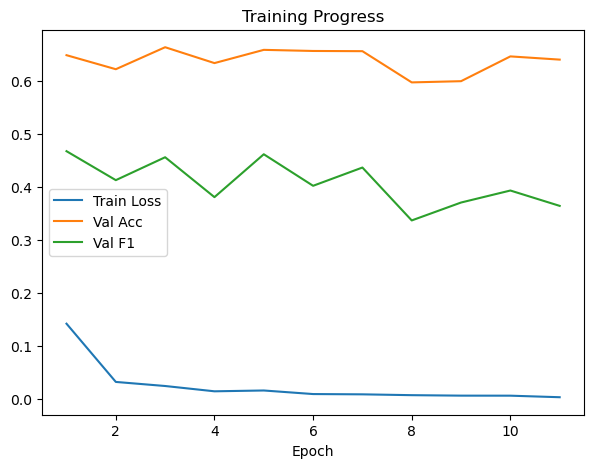

Early stopping at epoch 11 (no improvement for 8 epochs).

Best epoch = 3 | Best val accuracy = 0.6638
Best model saved to: best_mawnet.pt


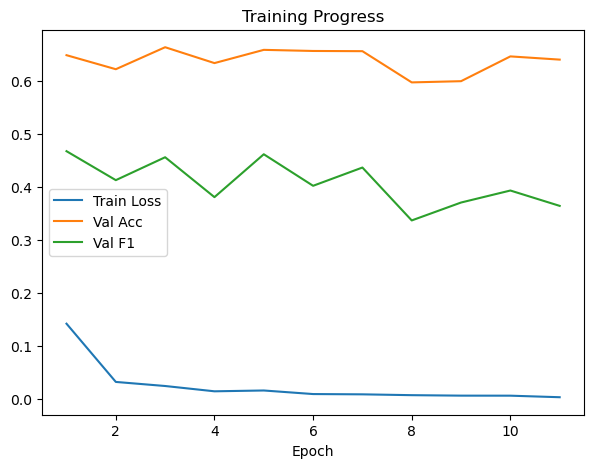

In [28]:
fig, ax, l_loss, l_acc, l_f1 = live_plot_init()
train_losses, val_accs, val_f1s = [], [], []
best_acc, best_epoch, no_improve = -1.0, 0, 0

for ep in range(1, EPOCHS+1):
    model.train()
    running, n = 0.0, 0
    # visualize train loss
    pbar = tqdm(train_dl, desc=f"Epoch {ep}/{EPOCHS}", leave=False)
    for xb, yb in pbar:
        xb = xb.to(device); 
        yb = yb.to(device)
        if yb.ndim == 2 and yb.size(1) == 1:
            yb = yb.squeeze(1)
        yb = yb.long()
        
        logits, _ = model(xb)
        loss = (criterion(logits, yb)) # squeeze/cast labels to long to match CrossEntropyLoss
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()   
                
        running += float(loss) * xb.size(0); n += xb.size(0)
        pbar.set_postfix(loss=float(loss))
    epoch_loss = running / max(n,1)
    train_losses.append(epoch_loss)

    # Validation metrics
    metrics = evaluate_cls_full(model, val_dl, num_classes)
    acc = metrics["acc"]; 
    f1 = metrics["f1"]  # keep your variable names for downstream uses
    val_accs.append(acc); 
    val_f1s.append(f1)
    scheduler.step()

    print(
    f"Epoch {ep:02d} | TrainLoss {epoch_loss:.4f} | "
    f"ValAcc {acc:.4f} | ValF1 {f1:.4f} | "
    f"AUC {metrics['auc']:.4f} | MCC {metrics['mcc']:.4f} | "
    f"Sens {metrics['sensitivity']:.4f} | Spec {metrics['specificity']:.4f}"
    )

    live_plot_update(ax, l_loss, l_acc, l_f1, train_losses, val_accs, val_f1s)
    
    # ---- save best by accuracy
    if acc > best_acc:
        best_acc = acc; 
        best_epoch = ep; 
        no_improve = 0
        
        ckpt = {
        "model": model.state_dict(),
        "epoch": ep,
        "val_acc": float(best_acc),
        "num_classes": num_classes,
        "config": { 
            "IMG_SIZE": IMG_SIZE,
            "BATCH_SIZE": BATCH_SIZE,
            "LR": LR,
            "AUGMENT": True,
        }},
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Early stopping at epoch {ep} (no improvement for {PATIENCE} epochs).")
            break

print(f"\nBest epoch = {best_epoch} | Best val accuracy = {best_acc:.4f}")
print(f"Best model saved to: {SAVE_BEST_PATH}")

**Saving Model**

Overall Accuracy: 0.6404
F1 Score: 0.3643

Classification Report:
              precision    recall  f1-score   support

           0     0.6360    0.9117    0.7493      5921
           1     0.6643    0.2510    0.3643      4124

    accuracy                         0.6404     10045
   macro avg     0.6502    0.5813    0.5568     10045
weighted avg     0.6476    0.6404    0.5912     10045



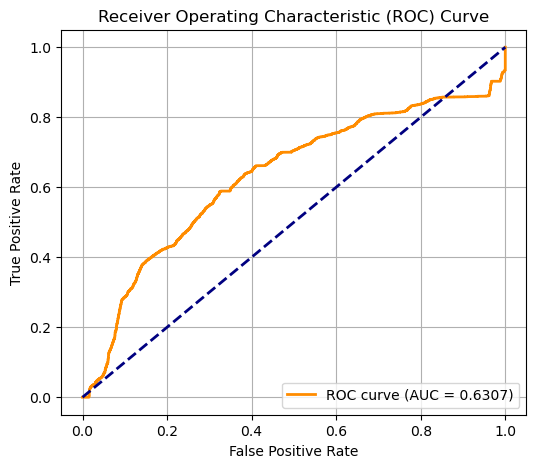

In [29]:
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import torch

# --- evaluate best model on validation or test loader ---
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for xb, yb in val_dl:  # change to test_dl if you want final test
        xb = xb.to(device)
        yb = yb.long().to(device)
        logits, _ = model(xb)
        probs = torch.softmax(logits, dim=1)
        pred = probs.argmax(dim=1)

        y_true.extend(yb.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
        if num_classes == 2:
            y_prob.extend(probs[:, 1].cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- overall accuracy + f1 ---
from sklearn.metrics import accuracy_score, f1_score
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="binary" if num_classes==2 else "macro")
print(f"Overall Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

# --- classification report ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# --- ROC Curve (binary only) ---
if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print("ROC curve only applies to binary classification.")


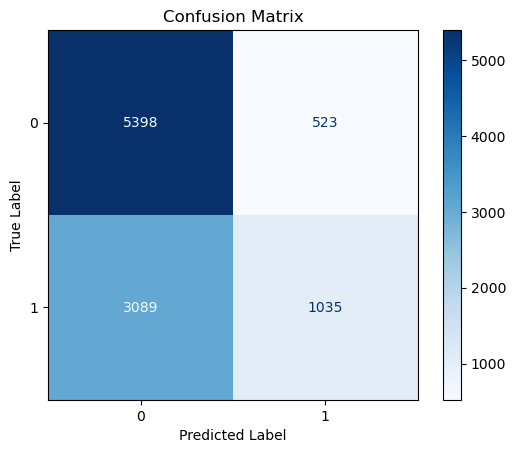


Confusion Matrix (raw counts):
 [[5398  523]
 [3089 1035]]


In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Optional: print raw matrix values too
print("\nConfusion Matrix (raw counts):\n", cm)
